# From `convexnn_pytorch_stepsize_fig.py`

In [1]:
import numpy as np
import dill
import pickle
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import time
import scipy
from scipy.sparse.linalg import LinearOperator
import torch
import sklearn.linear_model
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn as nn
import argparse
import random

In [2]:
def parse_args(inp=["--GD", "0", "--CVX", "0", "--n_epochs","100", "100", "--solver_cvx", "sgd"]):
    # Parse arguments
    parser = argparse.ArgumentParser()
    parser.add_argument('--GD', nargs=1, type=int, required=True)
    parser.add_argument('--CVX', nargs=1, type=int, required=True)
    parser.add_argument('--n_epochs', nargs=2, type=int, required=True)
    parser.add_argument('--solver_cvx', type=str, nargs=1, default="adam")
    parser.add_argument('--seed', type=int, default=42)
    args = parser.parse_args(inp)
    random.seed(a=args.seed)
    np.random.seed(seed=args.seed)
    torch.manual_seed(seed=args.seed)
    return args

class FCNetwork(nn.Module):
    def __init__(self, H, num_classes=10, input_dim=3072):
        self.num_classes = num_classes
        super(FCNetwork, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(input_dim, H, bias=False), nn.ReLU())
        self.layer2 = nn.Linear(H, num_classes, bias=False)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        out = self.layer2(self.layer1(x))
        return out
    
# functions for generating sign patterns
def check_if_already_exists(element_list, element):
    # check if element exists in element_list
    # where element is a numpy array
    for i in range(len(element_list)):
        if np.array_equal(element_list[i], element):
            return True
    return False

class PrepareData(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X)
        else:
            self.X = X
            
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)
        else:
            self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class PrepareData3D(Dataset):
    def __init__(self, X, y, z):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X)
        else:
            self.X = X
            
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)
        else:
            self.y = y
        
        if not torch.is_tensor(z):
            self.z = torch.from_numpy(z)
        else:
            self.z = z
        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.z[idx]

def generate_conv_sign_patterns(A2, P, verbose=False): 
    # generate convolutional sign patterns
    n, c, p1, p2 = A2.shape
    A = A2.reshape(n,int(c*p1*p2))
    fsize=9*c
    d=c*p1*p2;
    fs=int(np.sqrt(9))
    unique_sign_pattern_list = []  
    u_vector_list = []             

    for i in range(P): 
        # obtain a sign pattern
        ind1=np.random.randint(0,p1-fs+1)
        ind2=np.random.randint(0,p2-fs+1)
        u1p= np.zeros((c,p1,p2))
        u1p[:,ind1:ind1+fs,ind2:ind2+fs]=np.random.normal(0, 1, (fsize,1)).reshape(c,fs,fs)
        u1=u1p.reshape(d,1)
        sampled_sign_pattern = (np.matmul(A, u1) >= 0)[:,0]
        unique_sign_pattern_list.append(sampled_sign_pattern)
        u_vector_list.append(u1)

    if verbose:
        print("Number of unique sign patterns generated: " + str(len(unique_sign_pattern_list)))
    return len(unique_sign_pattern_list),unique_sign_pattern_list, u_vector_list

def generate_sign_patterns(A, P, verbose=False):
    # generate sign patterns
    n, d = A.shape
    sign_pattern_list = []  # sign patterns
    u_vector_list = []             # random vectors used to generate the sign paterns
    umat = np.random.normal(0, 1, (d,P))
    sampled_sign_pattern_mat = (np.matmul(A, umat) >= 0)
    for i in range(P):
        sampled_sign_pattern = sampled_sign_pattern_mat[:,i]
        sign_pattern_list.append(sampled_sign_pattern)
        u_vector_list.append(umat[:,i])
    if verbose:
        print("Number of sign patterns generated: " + str(len(sign_pattern_list)))
    return len(sign_pattern_list),sign_pattern_list, u_vector_list

def one_hot(labels, num_classes=10):
    y = torch.eye(num_classes) 
    return y[labels.long()] 

In [3]:
ARGS=parse_args()

# Standard Non-Convex Network

In [4]:
def loss_func_primal(yhat, y, model, beta):
    loss = 0.5 * torch.norm(yhat - y)**2
    
    ## l2 norm on first layer weights, l1 squared norm on second layer
    for layer, p in enumerate(model.parameters()):
        if layer == 0:
            loss += beta/2 * torch.norm(p)**2
        else:
            loss += beta/2 * sum([torch.norm(p[:, j], 1)**2 for j in range(p.shape[1])])
    
    return loss

def validation_primal(model, testloader, beta, device):
    test_loss = 0
    test_correct = 0

    for ix, (_x, _y) in enumerate(testloader):
        _x = Variable(_x).float().to(device)
        _y = Variable(_y).float().to(device)

        output = model.forward(_x)
        yhat = model(_x).float()

        loss = loss_func_primal(yhat, one_hot(_y).to(device), model, beta)

        test_loss += loss.item()
        test_correct += torch.eq(torch.argmax(yhat, dim=1), torch.squeeze(_y)).float().sum()

    return test_loss, test_correct

# solves nonconvex problem
def sgd_solver_pytorch_v2(ds, ds_test, num_epochs, num_neurons, beta, 
                         learning_rate, batch_size, solver_type, schedule, 
                          LBFGS_param, verbose=False, 
                        num_classes=10, D_in=3*1024, test_len=10000, 
                          train_len=50000, device='cuda'):
    
    device = torch.device(device)
    # D_in is input dimension, H is hidden dimension, D_out is output dimension.
    H, D_out = num_neurons, num_classes
    # create the model
    model = FCNetwork(H, D_out, D_in).to(device)
    
    if solver_type == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif solver_type == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#,
    elif solver_type == "adagrad":
        optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)#,
    elif solver_type == "adadelta":
        optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)#,
    elif solver_type == "LBFGS":
        optimizer = torch.optim.LBFGS(model.parameters(), history_size=LBFGS_param[0], max_iter=LBFGS_param[1])#,
        
    # arrays for saving the loss and accuracy    
    losses = np.zeros((int(num_epochs*np.ceil(train_len / batch_size))))
    accs = np.zeros(losses.shape)
    losses_test = np.zeros((num_epochs+1))
    accs_test = np.zeros((num_epochs+1))
    times = np.zeros((losses.shape[0]+1))
    times[0] = time.time()
    
    losses_test[0], accs_test[0] = validation_primal(model, ds_test, beta, device) # loss on the entire test set
    
    if schedule==1:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                           verbose=verbose,
                                                           factor=0.5,
                                                           eps=1e-12)
    elif schedule==2:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99)
        
    iter_no = 0
    for i in range(num_epochs):
        for ix, (_x, _y) in enumerate(ds):
            #=========make input differentiable=======================
            _x = Variable(_x).to(device)
            _y = Variable(_y).to(device)
            
            #========forward pass=====================================
            yhat = model(_x).float()
            
            loss = loss_func_primal(yhat, one_hot(_y).to(device), model, beta)/len(_y)
            correct = torch.eq(torch.argmax(yhat, dim=1), torch.squeeze(_y)).float().sum()/len(_y)
            
           
            optimizer.zero_grad() # zero the gradients on each pass before the update
            loss.backward() # backpropagate the loss through the model
            optimizer.step() # update the gradients w.r.t the loss

            losses[iter_no] = loss.item() # loss on the minibatch
            accs[iter_no] = correct
        
            iter_no += 1
            times[iter_no] = time.time()
        
        # get test loss and accuracy
        losses_test[i+1], accs_test[i+1] = validation_primal(model, ds_test, beta, device) # loss on the entire test set

        if i % 1 == 0:
            print("Epoch [{}/{}], loss: {} acc: {}, test loss: {} test acc: {}".format(i, num_epochs,
                    np.round(losses[iter_no-1], 3), np.round(accs[iter_no-1], 3), 
                    np.round(losses_test[i+1], 3)/test_len, np.round(accs_test[i+1]/test_len, 3)))
        if schedule>0:
            scheduler.step(losses[iter_no-1])
            
    return losses, accs, losses_test/test_len, accs_test/test_len, times, model


# Convex Network

In [5]:
class custom_cvx_layer(torch.nn.Module):
    def __init__(self, d, num_neurons, num_classes=10):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(custom_cvx_layer, self).__init__()
        
        # P x d x C
        self.v = torch.nn.Parameter(data=torch.zeros(num_neurons, d, num_classes), requires_grad=True)
        self.w = torch.nn.Parameter(data=torch.zeros(num_neurons, d, num_classes), requires_grad=True)

    def forward(self, x, sign_patterns):
        sign_patterns = sign_patterns.unsqueeze(2)
        x = x.view(x.shape[0], -1) # n x d
        
        Xv_w = torch.matmul(x, self.v - self.w) # P x N x C
        
        # for some reason, the permutation is necessary. not sure why
        DXv_w = torch.mul(sign_patterns, Xv_w.permute(1, 0, 2)) #  N x P x C
        y_pred = torch.sum(DXv_w, dim=1, keepdim=False) # N x C
        
        return y_pred
    
def get_nonconvex_cost(y, model, _x, beta, device):
    _x = _x.view(_x.shape[0], -1)
    Xv = torch.matmul(_x, model.v)
    Xw = torch.matmul(_x, model.w)
    Xv_relu = torch.max(Xv, torch.Tensor([0]).to(device))
    Xw_relu = torch.max(Xw, torch.Tensor([0]).to(device))
    
    prediction_w_relu = torch.sum(Xv_relu - Xw_relu, dim=0, keepdim=False)
    prediction_cost = 0.5 * torch.norm(prediction_w_relu - y)**2
    
    regularization_cost = beta * (torch.sum(torch.norm(model.v, dim=1)**2) + torch.sum(torch.norm(model.w, p=1, dim=1)**2))
    
    return prediction_cost + regularization_cost

def loss_func_cvxproblem(yhat, y, model, _x, sign_patterns, beta, rho, device):
    _x = _x.view(_x.shape[0], -1)
    
    # term 1
    loss = 0.5 * torch.norm(yhat - y)**2
    # term 2
    loss = loss + beta * torch.sum(torch.norm(model.v, dim=1))
    loss = loss + beta * torch.sum(torch.norm(model.w, dim=1))
    
    # term 3
    sign_patterns = sign_patterns.unsqueeze(2) # N x P x 1
    
    Xv = torch.matmul(_x, torch.sum(model.v, dim=2, keepdim=True)) # N x d times P x d x 1 -> P x N x 1
    DXv = torch.mul(sign_patterns, Xv.permute(1, 0, 2)) # P x N x 1
    relu_term_v = torch.max(-2*DXv + Xv.permute(1, 0, 2), torch.Tensor([0]).to(device))
    loss = loss + rho * torch.sum(relu_term_v)
    
    Xw = torch.matmul(_x, torch.sum(model.w, dim=2, keepdim=True))
    DXw = torch.mul(sign_patterns, Xw.permute(1, 0, 2))
    relu_term_w = torch.max(-2*DXw + Xw.permute(1, 0, 2), torch.Tensor([0]).to(device))
    loss = loss + rho * torch.sum(relu_term_w)
    
    return loss

def validation_cvxproblem(model, testloader, u_vectors, beta, rho, device):
    test_loss = 0
    test_correct = 0
    test_noncvx_cost = 0

    with torch.no_grad():
        for ix, (_x, _y) in enumerate(testloader):
            _x = Variable(_x).to(device)
            _y = Variable(_y).to(device)
            _x = _x.view(_x.shape[0], -1)
            _z = (torch.matmul(_x, torch.from_numpy(u_vectors).float().to(device)) >= 0)

            output = model.forward(_x, _z)
            yhat = model(_x, _z).float()

            loss = loss_func_cvxproblem(yhat, one_hot(_y).to(device), model, _x, _z, beta, rho, device)

            test_loss += loss.item()
            test_correct += torch.eq(torch.argmax(yhat, dim=1), _y).float().sum()

            test_noncvx_cost += get_nonconvex_cost(one_hot(_y).to(device), model, _x, beta, device)

    return test_loss, test_correct, test_noncvx_cost

def sgd_solver_cvxproblem(ds, ds_test, num_epochs, num_neurons, beta, 
                       learning_rate, batch_size, rho, u_vectors, 
                          solver_type, LBFGS_param, verbose=False,
                         n=60000, d=3072, num_classes=10, device='cpu'):
    device = torch.device(device)

    # create the model
    model = custom_cvx_layer(d, num_neurons, num_classes).to(device)
    
    if solver_type == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif solver_type == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#,
    elif solver_type == "adagrad":
        optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)#,
    elif solver_type == "adadelta":
        optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)#,
    elif solver_type == "LBFGS":
        optimizer = torch.optim.LBFGS(model.parameters(), history_size=LBFGS_param[0], max_iter=LBFGS_param[1])#,
    
    # arrays for saving the loss and accuracy 
    losses = np.zeros((int(num_epochs*np.ceil(n / batch_size))))
    accs = np.zeros(losses.shape)
    noncvx_losses = np.zeros(losses.shape)
    
    losses_test = np.zeros((num_epochs+1))
    accs_test = np.zeros((num_epochs+1))
    noncvx_losses_test = np.zeros((num_epochs+1))
    
    times = np.zeros((losses.shape[0]+1))
    times[0] = time.time()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                           verbose=verbose,
                                                           factor=0.5,
                                                           eps=1e-12)
    
    model.eval()
    losses_test[0], accs_test[0], noncvx_losses_test[0] = validation_cvxproblem(model, ds_test, u_vectors, beta, rho, device) # loss on the entire test set
    
    iter_no = 0
    print('starting training')
    for i in range(num_epochs):
        model.train()
        for ix, (_x, _y, _z) in enumerate(ds):
            #=========make input differentiable=======================
            _x = Variable(_x).to(device)
            _y = Variable(_y).to(device)
            _z = Variable(_z).to(device)
            
            #========forward pass=====================================
            yhat = model(_x, _z).float()
            
            loss = loss_func_cvxproblem(yhat, one_hot(_y).to(device), model, _x,_z, beta, rho, device)/len(_y)
            correct = torch.eq(torch.argmax(yhat, dim=1), _y).float().sum()/len(_y) # accuracy
            #=======backward pass=====================================
            optimizer.zero_grad() # zero the gradients on each pass before the update
            loss.backward() # backpropagate the loss through the model
            optimizer.step() # update the gradients w.r.t the loss

            losses[iter_no] = loss.item() # loss on the minibatch
            accs[iter_no] = correct
            noncvx_losses[iter_no] = get_nonconvex_cost(one_hot(_y).to(device), model, _x, beta, device)/len(_y)
        
            iter_no += 1
            times[iter_no] = time.time()
        
        model.eval()
        # get test loss and accuracy
        losses_test[i+1], accs_test[i+1], noncvx_losses_test[i+1] = validation_cvxproblem(model, ds_test, u_vectors, beta, rho, device) # loss on the entire test set
        
        if i % 1 == 0:
            print("Epoch [{}/{}], TRAIN: noncvx/cvx loss: {}, {} acc: {}. TEST: noncvx/cvx loss: {}, {} acc: {}".format(i, num_epochs,
                    np.round(noncvx_losses[iter_no-1], 3), np.round(losses[iter_no-1], 3), np.round(accs[iter_no-1], 3), 
                    np.round(noncvx_losses_test[i+1], 3)/10000, np.round(losses_test[i+1], 3)/10000, np.round(accs_test[i+1]/10000, 3)))
        
        scheduler.step(losses[iter_no-1])
        
    return noncvx_losses, accs, noncvx_losses_test/10000, accs_test/10000, times, losses, losses_test/10000

# Cifar 10 Download

cifar-10 -- using the version downloaded from http://www.cs.toronto.edu/~kriz/cifar.html

NOTE: This won't download the dataset if it already has been downloaded (:

In [6]:
import os
directory = os.path.abspath('')

import torchvision.datasets as datasets
import torchvision.transforms as transforms

normalize = transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])

train_dataset = datasets.CIFAR10(
    directory, train=True, download=True,
    transform=transforms.Compose([
    transforms.ToTensor(),
    normalize,
]))

test_dataset = datasets.CIFAR10(
    directory, train=False, download=True,
    transform=transforms.Compose([
    transforms.ToTensor(),
    normalize,
]))

Files already downloaded and verified
Files already downloaded and verified


## Data Extraction

In [7]:
print('Extracting the data')
dummy_loader= torch.utils.data.DataLoader(
    train_dataset, batch_size=50000, shuffle=False,
    pin_memory=True, sampler=None)
for A, y in dummy_loader:
    pass
Apatch=A.detach().clone()

A = A.view(A.shape[0], -1)
n,d=A.size()

Extracting the data


# Parameters

In [8]:
P = 4096
verbose = True 
GD_only=ARGS.GD[0]
CVX_only=ARGS.CVX[0]
beta = 1e-3 # regularization parameter
num_epochs1, batch_size =  ARGS.n_epochs[0], 1000 #
num_neurons = P # number of neurons is equal to number of hyperplane arrangements

## Dataloaders

In [9]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    pin_memory=True, sampler=None)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1000, shuffle=False,
    pin_memory=True)

# SGD Solver for Nonconvex Problem

In [10]:
if CVX_only==0:

    solver_type = "sgd" # pick: "sgd", "adam", "adagrad", "adadelta", "LBFGS"
    schedule=0 # learning rate schedule (0: Nothing, 1: ReduceLROnPlateau, 2: ExponentialLR)
    LBFGS_param = [10, 4] # these parameters are for the LBFGS solver
    learning_rate = 1e-2
    
    ## SGD1 constant    
    print('SGD1-training-mu={}'.format(learning_rate))
    results_noncvx_sgd1 = sgd_solver_pytorch_v2(train_loader, test_loader, num_epochs1, num_neurons, beta, 
                             learning_rate, batch_size, solver_type, schedule, 
                              LBFGS_param, verbose=True, 
                            num_classes=10, D_in=d, train_len=n )
    

    ## SGD2 constant    
    learning_rate = 5e-3
    print('SGD2-training-mu={}'.format(learning_rate))
    results_noncvx_sgd2 = sgd_solver_pytorch_v2(train_loader, test_loader, num_epochs1, num_neurons, beta, 
                             learning_rate, batch_size, solver_type, schedule,
                              LBFGS_param, verbose=True, 
                            num_classes=10, D_in=d, train_len=n )
  
    ## SGD3 constant
    learning_rate = 1e-3
    print('SGD3-training-mu={}'.format(learning_rate))
    results_noncvx_sgd3 = sgd_solver_pytorch_v2(train_loader, test_loader, num_epochs1, num_neurons, beta, 
                             learning_rate, batch_size, solver_type, schedule,
                              LBFGS_param, verbose=True, 
                            num_classes=10, D_in=d, train_len=n )

SGD1-training-mu=0.01
Epoch [0/100], loss: 0.393 acc: 0.412, test loss: 0.388315 test acc: 0.421
Epoch [1/100], loss: 0.358 acc: 0.51, test loss: 0.3758578 test acc: 0.462
Epoch [2/100], loss: 0.345 acc: 0.54, test loss: 0.372411 test acc: 0.465
Epoch [3/100], loss: 0.345 acc: 0.548, test loss: 0.3632651 test acc: 0.485
Epoch [4/100], loss: 0.329 acc: 0.551, test loss: 0.3584445 test acc: 0.501
Epoch [5/100], loss: 0.308 acc: 0.624, test loss: 0.3561467 test acc: 0.498
Epoch [6/100], loss: 0.317 acc: 0.593, test loss: 0.3563674 test acc: 0.504
Epoch [7/100], loss: 0.308 acc: 0.623, test loss: 0.358645 test acc: 0.5
Epoch [8/100], loss: 0.296 acc: 0.657, test loss: 0.3543707 test acc: 0.511
Epoch [9/100], loss: 0.304 acc: 0.647, test loss: 0.3514549 test acc: 0.513
Epoch [10/100], loss: 0.29 acc: 0.695, test loss: 0.3558609 test acc: 0.511
Epoch [11/100], loss: 0.293 acc: 0.665, test loss: 0.35982240000000004 test acc: 0.51
Epoch [12/100], loss: 0.282 acc: 0.697, test loss: 0.3538962 te

Epoch [4/100], loss: 0.35 acc: 0.515, test loss: 0.3634663 test acc: 0.478
Epoch [5/100], loss: 0.34 acc: 0.555, test loss: 0.3608221 test acc: 0.483
Epoch [6/100], loss: 0.331 acc: 0.563, test loss: 0.3590186 test acc: 0.492
Epoch [7/100], loss: 0.327 acc: 0.564, test loss: 0.3577984 test acc: 0.493
Epoch [8/100], loss: 0.316 acc: 0.62, test loss: 0.3591781 test acc: 0.492
Epoch [9/100], loss: 0.325 acc: 0.606, test loss: 0.3555668 test acc: 0.5
Epoch [10/100], loss: 0.316 acc: 0.595, test loss: 0.35402979999999995 test acc: 0.505
Epoch [11/100], loss: 0.314 acc: 0.608, test loss: 0.3535891 test acc: 0.503
Epoch [12/100], loss: 0.309 acc: 0.612, test loss: 0.35179340000000003 test acc: 0.512
Epoch [13/100], loss: 0.311 acc: 0.62, test loss: 0.35212519999999997 test acc: 0.508
Epoch [14/100], loss: 0.298 acc: 0.655, test loss: 0.3538086 test acc: 0.512
Epoch [15/100], loss: 0.301 acc: 0.638, test loss: 0.3522991 test acc: 0.515
Epoch [16/100], loss: 0.292 acc: 0.686, test loss: 0.35197

Epoch [8/100], loss: 0.366 acc: 0.473, test loss: 0.37351819999999997 test acc: 0.452
Epoch [9/100], loss: 0.36 acc: 0.487, test loss: 0.3722418 test acc: 0.455
Epoch [10/100], loss: 0.357 acc: 0.477, test loss: 0.3702474 test acc: 0.458
Epoch [11/100], loss: 0.358 acc: 0.507, test loss: 0.3691326 test acc: 0.462
Epoch [12/100], loss: 0.348 acc: 0.521, test loss: 0.3674406 test acc: 0.468
Epoch [13/100], loss: 0.347 acc: 0.508, test loss: 0.3667916 test acc: 0.467
Epoch [14/100], loss: 0.35 acc: 0.507, test loss: 0.3655457 test acc: 0.469
Epoch [15/100], loss: 0.348 acc: 0.501, test loss: 0.3644386 test acc: 0.47
Epoch [16/100], loss: 0.35 acc: 0.511, test loss: 0.36371190000000003 test acc: 0.475
Epoch [17/100], loss: 0.339 acc: 0.557, test loss: 0.36297240000000003 test acc: 0.473
Epoch [18/100], loss: 0.342 acc: 0.525, test loss: 0.362151 test acc: 0.476
Epoch [19/100], loss: 0.344 acc: 0.517, test loss: 0.3616928 test acc: 0.478
Epoch [20/100], loss: 0.339 acc: 0.539, test loss: 0.

In [13]:
torch.save(results_noncvx_sgd3[5].state_dict(),"ncvx_nn4096_solversgd_lr1e-3")

# Solver for Convex Problem

In [11]:
if GD_only ==0:

    rho = 1e-2 # coefficient to penalize the violated constraints
    solver_type = ARGS.solver_cvx[0] # pick: "sgd", "adam", "adagrad", "adadelta", "LBFGS"
    LBFGS_param = [10, 4] 
    batch_size = 1000
    num_epochs2, batch_size = ARGS.n_epochs[1], 1000 
 
    
    
    #  Convex
    print('Generating sign patterns')
    num_neurons,sign_pattern_list, u_vector_list = generate_sign_patterns(A, P, verbose)
    sign_patterns = np.array([sign_pattern_list[i].int().data.numpy() for i in range(num_neurons)])
    u_vectors = np.asarray(u_vector_list).reshape((num_neurons, A.shape[1])).T
    
    ds_train = PrepareData3D(X=A, y=y, z=sign_patterns.T)
    ds_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=1000, shuffle=False,
        pin_memory=True)


    #  Convex1
    learning_rate = 1e-6 # 1e-6 for sgd    
    print('Convex Random1-mu={}'.format(learning_rate))
    results_cvx1 = sgd_solver_cvxproblem(ds_train, test_loader, num_epochs2, num_neurons, beta, 
                            learning_rate, batch_size, rho, u_vectors, solver_type, LBFGS_param, verbose=True, 
                                             n=n, device='cuda')

    #  Convex2
    learning_rate = 5e-7 # 1e-6 for sgd    
    print('Convex Random2-mu={}'.format(learning_rate))
    results_cvx2 = sgd_solver_cvxproblem(ds_train, test_loader, num_epochs2, num_neurons, beta, 
                            learning_rate, batch_size, rho, u_vectors, solver_type, LBFGS_param, verbose=True, 
                                             n=n, device='cuda')
    
    
    
    #  Convex with convolutional patterns
    print('Generating conv sign patterns')
    num_neurons,sign_pattern_list, u_vector_list = generate_conv_sign_patterns(Apatch, P, verbose)
    sign_patterns = np.array([sign_pattern_list[i].int().data.numpy() for i in range(num_neurons)])
    u_vectors = np.asarray(u_vector_list).reshape((num_neurons, A.shape[1])).T
    
    ds_train = PrepareData3D(X=A, y=y, z=sign_patterns.T)
    ds_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
    
    #  Convex Conv1
    learning_rate = 1e-6       
    print('Convex Conv1-mu={}'.format(learning_rate))
    results_cvx_conv1 = sgd_solver_cvxproblem(ds_train, test_loader, num_epochs2, num_neurons, beta, 
                            learning_rate, batch_size, rho, u_vectors, solver_type, LBFGS_param, verbose=True, 
                                             n=n, device='cuda')

    #  Convex Conv2 
    learning_rate = 5e-7       
    print('Convex Conv2-mu={}'.format(learning_rate))
    results_cvx_conv2 = sgd_solver_cvxproblem(ds_train, test_loader, num_epochs2, num_neurons, beta, 
                            learning_rate, batch_size, rho, u_vectors, solver_type, LBFGS_param, verbose=True, 
                                             n=n, device='cuda')

Generating sign patterns
Number of sign patterns generated: 4096
Convex Random1-mu=1e-06
starting training
Epoch [0/100], TRAIN: noncvx/cvx loss: 0.425, 0.384 acc: 0.425. TEST: noncvx/cvx loss: 0.4223744, 0.3666936 acc: 0.467
Epoch [1/100], TRAIN: noncvx/cvx loss: 0.431, 0.34 acc: 0.532. TEST: noncvx/cvx loss: 0.4350988, 0.3546592 acc: 0.502
Epoch [2/100], TRAIN: noncvx/cvx loss: 0.431, 0.314 acc: 0.632. TEST: noncvx/cvx loss: 0.4396741, 0.3496703 acc: 0.508
Epoch [3/100], TRAIN: noncvx/cvx loss: 0.438, 0.299 acc: 0.631. TEST: noncvx/cvx loss: 0.44606419999999997, 0.3497245 acc: 0.512
Epoch [4/100], TRAIN: noncvx/cvx loss: 0.442, 0.289 acc: 0.684. TEST: noncvx/cvx loss: 0.4467685, 0.3462498 acc: 0.518
Epoch [5/100], TRAIN: noncvx/cvx loss: 0.44, 0.267 acc: 0.734. TEST: noncvx/cvx loss: 0.4459328, 0.3433451 acc: 0.53
Epoch [6/100], TRAIN: noncvx/cvx loss: 0.438, 0.259 acc: 0.769. TEST: noncvx/cvx loss: 0.449733, 0.3465515 acc: 0.522
Epoch [7/100], TRAIN: noncvx/cvx loss: 0.437, 0.251 ac

Epoch [64/100], TRAIN: noncvx/cvx loss: 0.447, 0.069 acc: 0.997. TEST: noncvx/cvx loss: 0.45750860000000004, 0.3662541 acc: 0.53
Epoch [65/100], TRAIN: noncvx/cvx loss: 0.447, 0.073 acc: 0.992. TEST: noncvx/cvx loss: 0.45736319999999997, 0.3658301 acc: 0.535
Epoch [66/100], TRAIN: noncvx/cvx loss: 0.441, 0.069 acc: 0.998. TEST: noncvx/cvx loss: 0.4557615, 0.3666644 acc: 0.529
Epoch [67/100], TRAIN: noncvx/cvx loss: 0.44, 0.067 acc: 0.999. TEST: noncvx/cvx loss: 0.45779620000000004, 0.367736 acc: 0.533
Epoch [68/100], TRAIN: noncvx/cvx loss: 0.445, 0.067 acc: 0.999. TEST: noncvx/cvx loss: 0.4584321, 0.3678174 acc: 0.531
Epoch [69/100], TRAIN: noncvx/cvx loss: 0.442, 0.066 acc: 1.0. TEST: noncvx/cvx loss: 0.4573763, 0.3678192 acc: 0.53
Epoch [70/100], TRAIN: noncvx/cvx loss: 0.444, 0.061 acc: 0.996. TEST: noncvx/cvx loss: 0.45761369999999996, 0.3682781 acc: 0.529
Epoch [71/100], TRAIN: noncvx/cvx loss: 0.446, 0.062 acc: 0.998. TEST: noncvx/cvx loss: 0.45796049999999994, 0.3690359 acc: 0.

Epoch [30/100], TRAIN: noncvx/cvx loss: 0.437, 0.181 acc: 0.925. TEST: noncvx/cvx loss: 0.450409, 0.3387424 acc: 0.542
Epoch [31/100], TRAIN: noncvx/cvx loss: 0.442, 0.18 acc: 0.938. TEST: noncvx/cvx loss: 0.4502609, 0.338102 acc: 0.543
Epoch [32/100], TRAIN: noncvx/cvx loss: 0.434, 0.177 acc: 0.931. TEST: noncvx/cvx loss: 0.45019390000000004, 0.3386449 acc: 0.54
Epoch [33/100], TRAIN: noncvx/cvx loss: 0.436, 0.172 acc: 0.952. TEST: noncvx/cvx loss: 0.4497871, 0.3391893 acc: 0.541
Epoch [34/100], TRAIN: noncvx/cvx loss: 0.44, 0.173 acc: 0.947. TEST: noncvx/cvx loss: 0.45140119999999995, 0.33973780000000003 acc: 0.539
Epoch [35/100], TRAIN: noncvx/cvx loss: 0.442, 0.176 acc: 0.937. TEST: noncvx/cvx loss: 0.45028090000000004, 0.33904470000000003 acc: 0.544
Epoch [36/100], TRAIN: noncvx/cvx loss: 0.441, 0.166 acc: 0.95. TEST: noncvx/cvx loss: 0.4506919, 0.3400859 acc: 0.541
Epoch [37/100], TRAIN: noncvx/cvx loss: 0.44, 0.167 acc: 0.953. TEST: noncvx/cvx loss: 0.45199579999999995, 0.340151

Epoch [95/100], TRAIN: noncvx/cvx loss: 0.439, 0.086 acc: 0.994. TEST: noncvx/cvx loss: 0.456029, 0.3566385 acc: 0.533
Epoch [96/100], TRAIN: noncvx/cvx loss: 0.439, 0.086 acc: 0.997. TEST: noncvx/cvx loss: 0.4547282, 0.3561498 acc: 0.535
Epoch [97/100], TRAIN: noncvx/cvx loss: 0.44, 0.083 acc: 0.996. TEST: noncvx/cvx loss: 0.4557521, 0.3565947 acc: 0.536
Epoch [98/100], TRAIN: noncvx/cvx loss: 0.443, 0.084 acc: 0.993. TEST: noncvx/cvx loss: 0.4565442, 0.3574643 acc: 0.533
Epoch [99/100], TRAIN: noncvx/cvx loss: 0.442, 0.083 acc: 0.993. TEST: noncvx/cvx loss: 0.4559316, 0.3570956 acc: 0.538
Generating conv sign patterns
Number of unique sign patterns generated: 4096
Convex Conv1-mu=1e-06
starting training
Epoch [0/100], TRAIN: noncvx/cvx loss: 0.425, 0.364 acc: 0.489. TEST: noncvx/cvx loss: 0.42698850000000005, 0.3645149 acc: 0.483
Epoch [1/100], TRAIN: noncvx/cvx loss: 0.432, 0.348 acc: 0.523. TEST: noncvx/cvx loss: 0.434359, 0.3524928 acc: 0.509
Epoch [2/100], TRAIN: noncvx/cvx loss:

Epoch [60/100], TRAIN: noncvx/cvx loss: 0.442, 0.083 acc: 0.996. TEST: noncvx/cvx loss: 0.458275, 0.354138 acc: 0.558
Epoch [61/100], TRAIN: noncvx/cvx loss: 0.44, 0.081 acc: 0.996. TEST: noncvx/cvx loss: 0.457028, 0.35464209999999996 acc: 0.556
Epoch [62/100], TRAIN: noncvx/cvx loss: 0.441, 0.077 acc: 0.992. TEST: noncvx/cvx loss: 0.4596229, 0.3561646 acc: 0.554
Epoch [63/100], TRAIN: noncvx/cvx loss: 0.444, 0.074 acc: 0.997. TEST: noncvx/cvx loss: 0.4583631, 0.3557682 acc: 0.557
Epoch [64/100], TRAIN: noncvx/cvx loss: 0.45, 0.076 acc: 0.994. TEST: noncvx/cvx loss: 0.46032920000000005, 0.35695659999999996 acc: 0.552
Epoch [65/100], TRAIN: noncvx/cvx loss: 0.439, 0.074 acc: 0.991. TEST: noncvx/cvx loss: 0.45775950000000004, 0.3561809 acc: 0.556
Epoch [66/100], TRAIN: noncvx/cvx loss: 0.442, 0.075 acc: 0.99. TEST: noncvx/cvx loss: 0.4587121, 0.3571954 acc: 0.555
Epoch [67/100], TRAIN: noncvx/cvx loss: 0.447, 0.073 acc: 0.996. TEST: noncvx/cvx loss: 0.45773010000000003, 0.3575545 acc: 0.

Epoch [26/100], TRAIN: noncvx/cvx loss: 0.439, 0.198 acc: 0.894. TEST: noncvx/cvx loss: 0.45014669999999996, 0.3314372 acc: 0.561
Epoch [27/100], TRAIN: noncvx/cvx loss: 0.438, 0.193 acc: 0.91. TEST: noncvx/cvx loss: 0.4530315, 0.33237890000000003 acc: 0.559
Epoch [28/100], TRAIN: noncvx/cvx loss: 0.432, 0.186 acc: 0.922. TEST: noncvx/cvx loss: 0.45158940000000003, 0.3319703 acc: 0.56
Epoch [29/100], TRAIN: noncvx/cvx loss: 0.44, 0.188 acc: 0.915. TEST: noncvx/cvx loss: 0.45116670000000003, 0.3320471 acc: 0.562
Epoch [30/100], TRAIN: noncvx/cvx loss: 0.444, 0.192 acc: 0.912. TEST: noncvx/cvx loss: 0.4516393, 0.3323134 acc: 0.566
Epoch [31/100], TRAIN: noncvx/cvx loss: 0.439, 0.185 acc: 0.928. TEST: noncvx/cvx loss: 0.4524654, 0.33201179999999997 acc: 0.564
Epoch [32/100], TRAIN: noncvx/cvx loss: 0.44, 0.181 acc: 0.934. TEST: noncvx/cvx loss: 0.4504083, 0.3317366 acc: 0.563
Epoch [33/100], TRAIN: noncvx/cvx loss: 0.44, 0.172 acc: 0.955. TEST: noncvx/cvx loss: 0.4506352, 0.3327038 acc: 0

Epoch [92/100], TRAIN: noncvx/cvx loss: 0.437, 0.098 acc: 0.99. TEST: noncvx/cvx loss: 0.4555607, 0.3458463 acc: 0.562
Epoch [93/100], TRAIN: noncvx/cvx loss: 0.435, 0.093 acc: 0.994. TEST: noncvx/cvx loss: 0.4560089, 0.3464023 acc: 0.56
Epoch [94/100], TRAIN: noncvx/cvx loss: 0.443, 0.097 acc: 0.987. TEST: noncvx/cvx loss: 0.4552634, 0.3460706 acc: 0.56
Epoch [95/100], TRAIN: noncvx/cvx loss: 0.438, 0.092 acc: 0.994. TEST: noncvx/cvx loss: 0.45643590000000006, 0.3469663 acc: 0.56
Epoch [96/100], TRAIN: noncvx/cvx loss: 0.439, 0.095 acc: 0.988. TEST: noncvx/cvx loss: 0.45530600000000004, 0.3466328 acc: 0.562
Epoch [97/100], TRAIN: noncvx/cvx loss: 0.438, 0.092 acc: 0.989. TEST: noncvx/cvx loss: 0.4554641, 0.3476056 acc: 0.56
Epoch [98/100], TRAIN: noncvx/cvx loss: 0.434, 0.09 acc: 0.993. TEST: noncvx/cvx loss: 0.4559098, 0.3475272 acc: 0.559
Epoch [99/100], TRAIN: noncvx/cvx loss: 0.441, 0.09 acc: 0.989. TEST: noncvx/cvx loss: 0.4562642, 0.3477364 acc: 0.56


# Plotting

Saving the objects


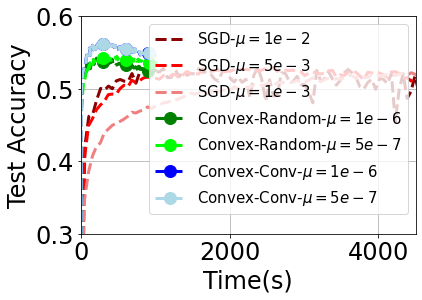

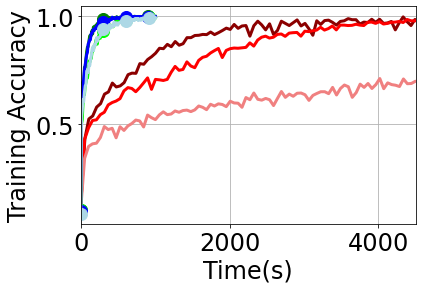

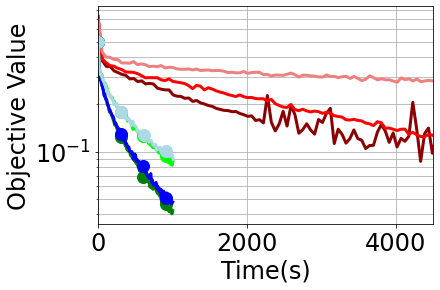

In [12]:
now = datetime.now() 
if GD_only==1 and CVX_only==0:


    
    results_noncvx_sgd1v2=results_noncvx_sgd1[:5]
    results_noncvx_sgd2v2=results_noncvx_sgd2[:5]
    results_noncvx_sgd3v2=results_noncvx_sgd3[:5]

 

    
    print('Saving the objects')
    torch.save([num_epochs1,results_noncvx_sgd1v2, results_noncvx_sgd2v2, results_noncvx_sgd3v2
                    ],'results_fig_gdonly_stepsize_cifar10_'+now.strftime("%d-%m-%Y_%H-%M-%S")+'.pt')
    

    
elif GD_only==0 and CVX_only==1:

    print('Saving the objects')
    torch.save([num_epochs2, results_cvx1,results_cvx2, 
                    results_cvx_conv1,results_cvx_conv2],'results_fig_cvxonly_stepsize_cifar10_'+now.strftime("%d-%m-%Y_%H-%M-%S")+'.pt')
    
else:

    results_noncvx_sgd1v2=results_noncvx_sgd1[:5]
    results_noncvx_sgd2v2=results_noncvx_sgd2[:5]
    results_noncvx_sgd3v2=results_noncvx_sgd3[:5]
    print('Saving the objects')
    torch.save([num_epochs1,num_epochs2,results_noncvx_sgd1v2, results_noncvx_sgd2v2, results_noncvx_sgd3v2, results_cvx1,results_cvx2, 
                    results_cvx_conv1,results_cvx_conv2],'results_fig_all_stepsize_cifar10_'+now.strftime("%d-%m-%Y_%H-%M-%S")+'.pt')

    import matplotlib.pyplot as plt

    skip=1#int(num_epochs1/num_epochs2)
    mark_sgd=10
    mark_cvx=30
    
    marker_size_sgd=10
    marker_size_cvx=12
    

    plt.gcf().set_facecolor("white")
    #fig,ax = plt.subplots()
    
    # plot
    fsize=24
    fsize_legend=15
    
    plt.rcParams.update({'font.size': 24})
    plt.xlabel('Time(s)',fontsize=fsize);  plt.grid()
    
    plot_no = 1 # select --> 0: cost, 1: accuracy
    
    
    
    num_all_iters1 = results_noncvx_sgd1v2[4].shape[0] - 1
    num_all_iters2 = results_cvx1[4].shape[0] - 1
    
    iters_per_epoch1 = num_all_iters1 // num_epochs1
    iters_per_epoch2 = num_all_iters2 // num_epochs2
    
    epoch_times_noncvx1 = results_noncvx_sgd1v2[4][0:num_all_iters1+1:iters_per_epoch1]-results_noncvx_sgd1v2[4][0]
    epoch_times_noncvx2 = results_noncvx_sgd2v2[4][0:num_all_iters1+1:iters_per_epoch1]-results_noncvx_sgd2v2[4][0]
    epoch_times_noncvx3 = results_noncvx_sgd3v2[4][0:num_all_iters1+1:iters_per_epoch1]-results_noncvx_sgd3v2[4][0]
    
    
    epoch_times_cvx1 = results_cvx1[4][0:num_all_iters2+1:iters_per_epoch2]-results_cvx1[4][0]
    epoch_times_cvx2 = results_cvx2[4][0:num_all_iters2+1:iters_per_epoch2]-results_cvx2[4][0]
    
    epoch_times_cvx_conv1= results_cvx_conv1[4][0:num_all_iters2+1:iters_per_epoch2]-results_cvx_conv1[4][0]
    epoch_times_cvx_conv2= results_cvx_conv2[4][0:num_all_iters2+1:iters_per_epoch2]-results_cvx_conv2[4][0]
    
    
    plt.grid()
    
    # To plot results in the validation set
    plt.plot( epoch_times_noncvx1[::skip],results_noncvx_sgd1v2[plot_no+2][::skip],'--', color='darkred', markevery=mark_sgd,linewidth=3.0, markersize=marker_size_sgd,label="SGD-$\mu=1e-2$")
    plt.plot( epoch_times_noncvx2[::skip],results_noncvx_sgd2v2[plot_no+2][::skip],'--', color='red', markevery=mark_sgd,linewidth=3.0, markersize=marker_size_sgd,label="SGD-$\mu=5e-3$")
    plt.plot( epoch_times_noncvx3[::skip],results_noncvx_sgd3v2[plot_no+2][::skip],'--', color='lightcoral', markevery=mark_sgd,linewidth=3.0, markersize=marker_size_sgd,label="SGD-$\mu=1e-3$")
    
    
    plt.plot( epoch_times_cvx1,results_cvx1[plot_no+2],  'o--', color='g', markevery=mark_cvx,linewidth=3.0, markersize=marker_size_cvx,label="Convex-Random-$\mu=1e-6$")
    plt.plot( epoch_times_cvx2,results_cvx2[plot_no+2],  'o--', color='lime', markevery=mark_cvx,linewidth=3.0, markersize=marker_size_cvx,label="Convex-Random-$\mu=5e-7$")
    
    plt.plot( epoch_times_cvx_conv1,results_cvx_conv1[plot_no+2],  'o--', color='b', markevery=mark_cvx,linewidth=3.0, markersize=marker_size_cvx,label="Convex-Conv-$\mu=1e-6$")
    plt.plot( epoch_times_cvx_conv2,results_cvx_conv1[plot_no+2],  'o--', color='lightblue', markevery=mark_cvx,linewidth=3.0, markersize=marker_size_cvx,label="Convex-Conv-$\mu=5e-7$")
    

    plt.legend(prop={'size': fsize_legend})
    plt.ylabel("Test Accuracy",fontsize=fsize)
    plt.ylim(0.3, 0.6)
    plt.xlim(0, 4500)
    
    plt.grid()
    plt.savefig('cifar_multiclass_stepsize_testacc.png', format='png', bbox_inches='tight')
    
    
    plt.figure()
    # To plot training  acc
    
    plt.xlabel('Time(s)',fontsize=fsize)  
    plt.grid()

    p11=results_noncvx_sgd1v2[1].reshape(-1,1)
    p12=results_noncvx_sgd2v2[1].reshape(-1,1)
    p13=results_noncvx_sgd3v2[1].reshape(-1,1)
    
    p21=results_cvx1[1].reshape(-1,1)
    p22=results_cvx2[1].reshape(-1,1)
    
    p31=results_cvx_conv1[1].reshape(-1,1)
    p32=results_cvx_conv2[1].reshape(-1,1)
    

    
    n=50000
    batch_size1=1000
    batch_size2=1000
    
    plt.plot(epoch_times_noncvx1[:-1][::skip],p11[np.arange(num_epochs1)*int(n/batch_size1)][::skip],'-',color='darkred', markevery=mark_sgd,linewidth=3, markersize=marker_size_sgd,label="SGD-$\mu=1e-2$")
    plt.plot(epoch_times_noncvx2[:-1][::skip],p12[np.arange(num_epochs1)*int(n/batch_size1)][::skip],'-',color='red', markevery=mark_sgd,linewidth=3, markersize=marker_size_sgd,label="SGD-$\mu=5e-2$")
    plt.plot(epoch_times_noncvx3[:-1][::skip],p13[np.arange(num_epochs1)*int(n/batch_size1)][::skip],'-',color='lightcoral', markevery=mark_sgd,linewidth=3, markersize=marker_size_sgd,label="SGD-$\mu=1e-3$")
    
    plt.plot( epoch_times_cvx1[:-1],p21[np.arange(num_epochs2)*int(n/batch_size2)] ,'o-',color='g', markevery=mark_cvx,linewidth=3, markersize=marker_size_cvx,label="Convex-Random-$\mu=1e-6$")
    plt.plot( epoch_times_cvx2[:-1],p22[np.arange(num_epochs2)*int(n/batch_size2)] ,'o-',color='lime', markevery=mark_cvx,linewidth=3, markersize=marker_size_cvx,label="Convex-Random-$\mu=5e-7$")
    
    plt.plot( epoch_times_cvx_conv1[:-1],p31[np.arange(num_epochs2)*int(n/batch_size2)] ,'o-', color='b',markevery=mark_cvx,linewidth=3, markersize=marker_size_cvx,label="Convex-Conv-$\mu=1e-6$")
    plt.plot( epoch_times_cvx_conv2[:-1],p32[np.arange(num_epochs2)*int(n/batch_size2)] ,'o-', color='lightblue',markevery=mark_cvx,linewidth=3, markersize=marker_size_cvx,label="Convex-Conv-$\mu=5e-7$")
    

    plt.xlim(0, 4500)
    
    plt.ylabel("Training Accuracy",fontsize=fsize)
    plt.grid()
    matplotlib.pyplot.grid(True, which="both")
    plt.savefig('cifar_multiclass_stepsize_tracc.png', format='png', bbox_inches='tight')

    
    # To plot training loss

    plt.figure()
    
    plt.xlabel('Time(s)',fontsize=fsize)  
    plt.grid()
    p11=results_noncvx_sgd1v2[0].reshape(-1,1)
    p12=results_noncvx_sgd2v2[0].reshape(-1,1)
    p13=results_noncvx_sgd3v2[0].reshape(-1,1)
    
    p21=results_cvx1[5].reshape(-1,1)
    p22=results_cvx2[5].reshape(-1,1)
    
    p31=results_cvx_conv1[5].reshape(-1,1)
    p32=results_cvx_conv2[5].reshape(-1,1)
    

    
    n=50000
    batch_size1=1000
    batch_size2=1000
    
    plt.semilogy(epoch_times_noncvx1[:-1][::skip],p11[np.arange(num_epochs1)*int(n/batch_size1)][::skip],'-',color='darkred', markevery=mark_sgd,linewidth=3, markersize=marker_size_sgd,label="SGD-$\mu=1e-2$")
    plt.semilogy(epoch_times_noncvx2[:-1][::skip],p12[np.arange(num_epochs1)*int(n/batch_size1)][::skip],'-',color='red', markevery=mark_sgd,linewidth=3, markersize=marker_size_sgd,label="SGD-$\mu=5e-2$")
    plt.semilogy(epoch_times_noncvx3[:-1][::skip],p13[np.arange(num_epochs1)*int(n/batch_size1)][::skip],'-',color='lightcoral', markevery=mark_sgd,linewidth=3, markersize=marker_size_sgd,label="SGD-$\mu=1e-3$")
    
    plt.semilogy( epoch_times_cvx1[:-1],p21[np.arange(num_epochs2)*int(n/batch_size2)] ,'o-',color='g', markevery=mark_cvx,linewidth=3, markersize=marker_size_cvx,label="Convex-Random-$\mu=1e-6$")
    plt.semilogy( epoch_times_cvx2[:-1],p22[np.arange(num_epochs2)*int(n/batch_size2)] ,'o-',color='lime', markevery=mark_cvx,linewidth=3, markersize=marker_size_cvx,label="Convex-Random-$\mu=5e-7$")
    
    plt.semilogy( epoch_times_cvx_conv1[:-1],p31[np.arange(num_epochs2)*int(n/batch_size2)] ,'o-', color='b',markevery=mark_cvx,linewidth=3, markersize=marker_size_cvx,label="Convex-Conv-$\mu=1e-6$")
    plt.semilogy( epoch_times_cvx_conv2[:-1],p32[np.arange(num_epochs2)*int(n/batch_size2)] ,'o-', color='lightblue',markevery=mark_cvx,linewidth=3, markersize=marker_size_cvx,label="Convex-Conv-$\mu=5e-7$")
    

    plt.xlim(0, 4500)
    
    plt.ylabel("Objective Value",fontsize=fsize)
    plt.grid()
    matplotlib.pyplot.grid(True, which="both")
    plt.savefig('cifar_multiclass_stepsize_obj.png', format='png', bbox_inches='tight')